# Goal

We will attemp to convert English into Pig Latin.  We will use the Text8 data as a corpus of text.  The modeling will be done using a sequence of characters and the input sequence will be the sequence of characters for one word.  We will use the method described [here](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf) 

<img src="S2S.png">

Attention: https://arxiv.org/pdf/1412.7449.pdf

# Import functions

In [1]:
import pickle
import tensorflow as tf
import numpy as np
import string
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
%matplotlib inline

# Import data

In [2]:
words = pickle.load(open('t8_words.p'))
words_pl = pickle.load(open('t8_words_pl.p'))

In [3]:
print zip(words[:10],words_pl[:10])

[('biennials', 'iennialsbay'), ('tripolitan', 'ipolitantray'), ('mdbg', 'mdbgay'), ('roadgear', 'oadgearray'), ('vang', 'angvay'), ('nunnery', 'unnerynay'), ('sowell', 'owellsay'), ('brownpride', 'ownpridebray'), ('vani', 'anivay'), ('woods', 'oodsway')]


# Create validation set

Taken from [here](https://en.oxforddictionaries.com/explore/weird-and-wonderful-words)

In [4]:
def lessT(x):
    if x <= 10:
        return True
    return False

In [5]:
uncommon = ['abaya','bardolatry','blatherski','couthy','deterge','eyewater','saudade',
            'tokoloshe','wittol','vomitous','waitron']
assert (not any([u in words for u in uncommon]))
assert all(map(lessT,map(len,uncommon)))

# Padding inputs and outputs

There is no good way to handle sequences of multiple lengths (see [here](https://www.tensorflow.org/tutorials/seq2seq)).  So we pad inputs and outputs to fixed lengths.

In [6]:
# find maximum length of input
max_in = 0
ind = 0
for i,w in enumerate(words):
    if len(w)> max_in:
        max_in = len(w)
        ind = i
print max_in, words[ind]

10 tripolitan


In [7]:
# find maximum length of input
max_out = 0
ind = 0
for i,w in enumerate(words_pl):
    if len(w)> max_out:
        max_out = len(w)
        ind = i
print max_out, words_pl[ind]

13 altagraciaway


In [8]:
pad_char = '~'
def pad_in(w):
    while(len(w)<max_in):
        w = pad_char+w
    return w

def pad_out(w):
    while(len(w)<max_out):
        w = w+pad_char
    return w

def un_pad(w):
    return w.replace(pad_char,'')

In [9]:
print pad_in(words[0])
print pad_out(words_pl[0])

~biennials
iennialsbay~~


# Vectorize data

In [10]:
alphabet = string.ascii_lowercase+'~'
alphabet_size = len(alphabet)+1 #need to add one for the end of sequence key

#returns a unique integer for the letter
def char2id(x):
    return alphabet.find(x)

#return a one hot encoded vector of the letter
def one_hot(l):
    r = np.zeros(alphabet_size)
    r[char2id(l)] = 1.0
    return r

#return the letter of the one-hot encoded letter
def un_one_hot(v):
    ind = np.argmax(v)
#     if ind >= alphabet_size-2:
    if ind == alphabet_size-1:
        return ''
    else:
        return alphabet[ind]

#returns the the End of Sequence vector
def getEOSvec():
    r = np.zeros(alphabet_size)
    r[alphabet_size-1] = 1.0
    return r

#returns the word a matrix of one hot encoded vectors
def vectorizeWord(w):
    r = np.ndarray((len(w)+1,alphabet_size))
    for i,l in enumerate(w):
        r[i] = one_hot(l)
    r[len(w)] = getEOSvec()
    return r

#returns the string of the vectorized word
def unvectorizeWord(M):
    r = ''
    for i in xrange(M.shape[0]):
        r += un_one_hot(M[i])
    return r

# Batch Generator

In [11]:
batch_size=30

In [12]:
class Batch(object):
    def __init__(self,words,words_pl,batch_size):
        self.words = words
        self.words_pl = words_pl
        self.batch_size = batch_size
        self.size = len(words)
        self.segment_size = self.size/batch_size
        self.cursors = [b*self.segment_size for b in range(batch_size)]
        #self.batch = np.ndarray(self.batch_size)
    def nextBatch(self,reverse = True):
        if reverse:
            x = np.array([vectorizeWord(pad_in(words[c][::-1])) for c in self.cursors])
        else:
            x = np.array([vectorizeWord(pad_in(words[c])) for c in self.cursors])
        y = np.array([vectorizeWord(pad_out(words_pl[c])) for c in self.cursors])
        self.cursors = [(c+1)%self.size for c in self.cursors]
        return x,y

# Deep LSTM

https://arxiv.org/pdf/1409.2329.pdf

<img src="OtherLSTM.png">  <img src="stacked_LSTM.png", width = "25%", height = "25%">

In [13]:
a1 = tf.constant([[1,2],[3,4]])
b1 = tf.slice(a1,[0,0],[2,1])

In [14]:
sess2 = tf.Session()
sess2.run(b1)

array([[1],
       [3]], dtype=int32)

In [135]:
#NOTE: the +1 in max_in+1 and max_out+1 happens because the end token is needed

num_nodes = 30
g = tf.Graph()
with g.as_default():
    #input sequence
    input_sequence = list()
    for i in range(max_in+1):
        input_sequence.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
    
    #target sequence
    target_sequence = list()
    for i in range(max_out+1):
        target_sequence.append(tf.placeholder(tf.float32,shape=(batch_size,alphabet_size)))
        
    
    #the previous state that gets fed into the cell
    state_0 = tf.constant(0.0,dtype=tf.float32,shape=[batch_size,num_nodes])
    hidden_0 = tf.constant(0.0,dtype=tf.float32,shape=[batch_size,num_nodes])
    #for validation inference
    state_0v = tf.constant(0.0,dtype=tf.float32,shape=[1,num_nodes])
    hidden_0v = tf.constant(0.0,dtype=tf.float32,shape=[1,num_nodes])
    
    def create_LSTM_Variables(num_nodes,Name,is_input=False,is_second=False):
        if is_input:
            fx = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'fx')
            ix = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'ix')
            cx = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'cx')
            ox = tf.Variable(tf.truncated_normal([num_nodes+alphabet_size, num_nodes], -0.08, 0.08),name=Name+'ox')
        elif is_second:
            fx = tf.Variable(tf.truncated_normal([3*num_nodes, num_nodes], -0.08, 0.08),name=Name+'fx')
            ix = tf.Variable(tf.truncated_normal([3*num_nodes, num_nodes], -0.08, 0.08),name=Name+'ix')
            cx = tf.Variable(tf.truncated_normal([3*num_nodes, num_nodes], -0.08, 0.08),name=Name+'cx')
            ox = tf.Variable(tf.truncated_normal([3*num_nodes, num_nodes], -0.08, 0.08),name=Name+'ox')
        else:
            fx = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'fx')
            ix = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'ix')
            cx = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'cx')
            ox = tf.Variable(tf.truncated_normal([2*num_nodes, num_nodes], -0.08, 0.08),name=Name+'ox')
        fb = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'fb')
        ib = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'ib')
        cb = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'cb')
        ob = tf.Variable(tf.zeros([1, num_nodes]),name=Name+'ob')
        return[[fx,ix,cx,ox],[fb,ib,cb,ob]]
    
    e1_var = create_LSTM_Variables(num_nodes,'e1',is_input = True)
    e2_var = create_LSTM_Variables(num_nodes,'e2')
    e3_var = create_LSTM_Variables(num_nodes,'e3')
    
    d1_var = create_LSTM_Variables(num_nodes,'d1',is_input = True)
    d2_var = create_LSTM_Variables(num_nodes,'d2',is_second = True)
    d3_var = create_LSTM_Variables(num_nodes,'d3')
    
    #softmax
    W_softmax = tf.Variable(tf.truncated_normal([num_nodes,alphabet_size],-0.08,0.08))
    b_softmax = tf.Variable(tf.zeros([1,alphabet_size]))
    
    #model
    #hl is the previous hiddent layer from current time step but previous  layer
    #ht is the previous hidden layer from the current layer but previous timestep
    #state is the previous state from the same layer but previous timestep
    def LSTM(hl,ht,state,varrs):
        #get variables out
        x,b=varrs[0],varrs[1]
        fx,ix,cx,ox = x[0],x[1],x[2],x[3]
        fb,ib,cb,ob = b[0],b[1],b[1],b[3]
        
        #computations
        input_chan = tf.concat([hl,ht],1)
        forget_gate = tf.sigmoid(tf.matmul(input_chan,fx)+fb)
        insert_gate = tf.sigmoid(tf.matmul(input_chan,ix)+ib)
        output_gate = tf.sigmoid(tf.matmul(input_chan,ox)+ob)
        candidate = tf.tanh(tf.matmul(input_chan,cx)+cb)
        state = forget_gate * state + insert_gate * candidate
        h = output_gate * tf.tanh(state)
        return h, state
    
    def attention(h,d,encoder_size,decoder_size,attention_size=27,reuse=True):
        """
        h : encoder states each element is [N,encoder_size]. array is length encoder_length
        d : decoding query [N,decoder_size]
        
        Returns
        new query d_prime [N,encoder_size]
        an attention vector a [encoder_length]
        """
        with tf.variable_scope('attention',reuse=reuse):
            W_1=tf.get_variable('W_1',shape=[encoder_size,attention_size],initializer=tf.random_normal_initializer())
            W_2=tf.get_variable('W_2',shape=[decoder_size,attention_size],initializer=tf.random_normal_initializer())
            v = tf.get_variable('v',shape=[attention_size,1])
        
        u = []
        for h_i in h:
            u_i = tf.matmul(tf.tanh(tf.matmul(h_i,W_1)+tf.matmul(d,W_2)),v)
            u.append(u_i)
        
        u=tf.concat(u,axis=1) #[N,encoder_length]
        a = tf.nn.softmax(u)
        d_prime = tf.reduce_sum(tf.expand_dims(a,axis=1) * tf.reshape(tf.concat(h,1),
                                            (-1,encoder_size,len(h))),axis=2)
        
        return d_prime,a[0,:]
        
    
    def model(input_sequence,train = True):
        #Encode sequence
        memory = list()
        for i in range(max_in+1):
            if i == 0:
                if train:
                    state1,h1 = state_0,hidden_0
                    state2,h2 = state_0,hidden_0
                    state3,h3 = state_0,hidden_0
                else:
                    state1,h1 = state_0v,hidden_0v
                    state2,h2 = state_0v,hidden_0v
                    state3,h3 = state_0v,hidden_0v

            h1,state1 = LSTM(h1,input_sequence[i],state1,e1_var) #layer 1
            h2,state2 = LSTM(h2,h1,state2,e2_var) #layer 2
            h3,state3 = LSTM(h3,h2,state3,e3_var) #layer 3
            memory.append(h3) #add output as to the memory for attention

#         memory2=tf.concat(memory,1)
#         #print(memory2.get_shape())
#         #print(tf.reshape(memory2,(batch_size,num_nodes,-1)).shape)
        
        #Decode sequence
        attention_values = list()
        logits_list = list()
        for i in range(max_out+1):
            if i == 0:
                h1,state1 = LSTM(h1,input_sequence[-1],state1,d1_var) #layer 1
                if train:
                    d_prime,a = attention(h=memory,d=h1,encoder_size=num_nodes,decoder_size=num_nodes,reuse=False)
                else:
                    d_prime,a = attention(h=memory,d=h1,encoder_size=num_nodes,decoder_size=num_nodes,reuse=True)

            else:
                h1,state1 = LSTM(h1,tf.nn.softmax(logit),state1,d1_var) #layer 1
                d_prime,a = attention(h=memory,d=h1,encoder_size=num_nodes,decoder_size=num_nodes)
            h2,state2 = LSTM(h2,tf.concat([d_prime,h1],axis=1),state2,d2_var) #layer 2
            h3,state3 = LSTM(h3,h2,state3,d3_var) #layer 3

            logit =tf.matmul(h3,W_softmax)+b_softmax
            logits_list.append(logit)
            attention_values.append(a)

        logits = tf.concat(logits_list,0)
        print(attention_values[0].shape)
        attention_values=tf.transpose(tf.stack(attention_values,0))
        print(attention_values.shape)
        return logits,attention_values
    
    #train
    logits_train,attention_values = model(input_sequence)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_train,labels=tf.concat(target_sequence,0)))
    opt = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)
    
    #inference train
    pred = tf.nn.softmax(logits_train)
    
    saver = tf.train.Saver()
        
    init = tf.global_variables_initializer()

(11,)
(11, 14)


In [136]:
sess = tf.Session(graph = g)
sess.run(init)
b = Batch(words,words_pl,batch_size)
losses = []

In [137]:
# saver.restore(sess,os.getcwd()+'/model3_attention.ckpt')

In [152]:
num_steps = 5001
# num_steps = 11
for s in tqdm(range(num_steps)):
    fd = {}
    x,y = b.nextBatch(reverse=False)
    for i in range(len(x[0,:,0])):
        fd[input_sequence[i]] = x[:,i,:]
    for i in range(len(y[0,:,0])):
        fd[target_sequence[i]] = y[:,i,:]
    
    l,_ = sess.run([loss,opt],feed_dict = fd)
    losses.append(l)
    if s % 100 == 0:
        translated = sess.run([pred],feed_dict=fd)[0]
        #onlt check the first word
        fw_o = np.ndarray((max_out,alphabet_size))
        for i in range(max_out):
            fw_o[i]=translated[i*batch_size]
    
        print 'loss: ',l
        print 'Input:          ',unvectorizeWord(x[0])#[::-1]
        print 'Output:         ',unvectorizeWord(fw_o)
        print 'Correct Output: ',unvectorizeWord(y[0])
        print ' '
#save_path = saver.save(sess,os.getcwd()+'/model3_attention.ckpt')

  0%|          | 3/5001 [00:00<08:34,  9.72it/s]

loss:  0.302704
Input:           ~~~~gullit
Output:          ullitgay~~~~~
Correct Output:  ullitgay~~~~~
 


  2%|▏         | 103/5001 [00:08<06:43, 12.14it/s]

loss:  0.182563
Input:           ~~~~eactor
Output:          eactorway~~~~
Correct Output:  eactorway~~~~
 


  4%|▍         | 203/5001 [00:16<06:30, 12.29it/s]

loss:  0.185674
Input:           ~~~~~laide
Output:          aidelay~~~~~~
Correct Output:  aidelay~~~~~~
 


  6%|▌         | 303/5001 [00:24<06:20, 12.34it/s]

loss:  0.19154
Input:           ~bananaman
Output:          ananmmanbay~~
Correct Output:  ananamanbay~~
 


  8%|▊         | 403/5001 [00:32<06:09, 12.43it/s]

loss:  0.380778
Input:           ~~~~~dimps
Output:          impsday~~~~~~
Correct Output:  impsday~~~~~~
 


 10%|█         | 503/5001 [00:40<06:00, 12.49it/s]

loss:  0.259007
Input:           ~sadlamulk
Output:          adlamumysay~~
Correct Output:  adlamulksay~~
 


 12%|█▏        | 603/5001 [00:48<05:51, 12.51it/s]

loss:  0.174261
Input:           ~~~~~~neal
Output:          ealnay~~~~~~~
Correct Output:  ealnay~~~~~~~
 


 14%|█▍        | 702/5001 [00:56<05:45, 12.43it/s]

loss:  0.192062
Input:           ~~~relearn
Output:          elearnray~~~~
Correct Output:  elearnray~~~~
 


 16%|█▌        | 802/5001 [01:04<05:39, 12.35it/s]

loss:  0.163568
Input:           ~~~lecanii
Output:          ecaniilay~~~~
Correct Output:  ecaniilay~~~~
 


 18%|█▊        | 902/5001 [01:12<05:30, 12.39it/s]

loss:  0.214975
Input:           ~~~~~bobak
Output:          obakbay~~~~~~
Correct Output:  obakbay~~~~~~
 


 20%|██        | 1002/5001 [01:21<05:23, 12.36it/s]

loss:  0.276154
Input:           ~~~~schack
Output:          ackschay~~~~~
Correct Output:  ackschay~~~~~
 


 22%|██▏       | 1102/5001 [01:28<05:14, 12.39it/s]

loss:  0.146928
Input:           ~~~~~~rels
Output:          elsray~~~~~~~
Correct Output:  elsray~~~~~~~
 


 24%|██▍       | 1202/5001 [01:36<05:06, 12.40it/s]

loss:  0.217687
Input:           ~proffered
Output:          offeredpray~~
Correct Output:  offeredpray~~
 


 26%|██▌       | 1302/5001 [01:45<04:58, 12.38it/s]

loss:  0.169613
Input:           ~pombalina
Output:          ombalinapay~~
Correct Output:  ombalinapay~~
 


 28%|██▊       | 1402/5001 [01:53<04:50, 12.38it/s]

loss:  0.228216
Input:           ~~furihime
Output:          uribimefay~~~
Correct Output:  urihimefay~~~
 


 30%|███       | 1502/5001 [02:02<04:45, 12.27it/s]

loss:  0.197745
Input:           ~~bulafiji
Output:          ulabomibay~~~
Correct Output:  ulafijibay~~~
 


 32%|███▏      | 1602/5001 [02:10<04:36, 12.30it/s]

loss:  0.151861
Input:           ~manouvres
Output:          anouvresmay~~
Correct Output:  anouvresmay~~
 


 34%|███▍      | 1702/5001 [02:18<04:27, 12.32it/s]

loss:  0.216108
Input:           ~~suburban
Output:          uburhansay~~~
Correct Output:  uburbansay~~~
 


 36%|███▌      | 1802/5001 [02:26<04:19, 12.34it/s]

loss:  0.168616
Input:           ~biollante
Output:          iollantebay~~
Correct Output:  iollantebay~~
 


 38%|███▊      | 1902/5001 [02:34<04:11, 12.34it/s]

loss:  0.177692
Input:           ~aryabhata
Output:          aryahhataway~
Correct Output:  aryabhataway~
 


 40%|████      | 2002/5001 [02:42<04:02, 12.34it/s]

loss:  0.153501
Input:           ~maroilles
Output:          aroillesmay~~
Correct Output:  aroillesmay~~
 


 42%|████▏     | 2102/5001 [02:50<03:54, 12.36it/s]

loss:  0.122396
Input:           ~marrubium
Output:          arrubiummay~~
Correct Output:  arrubiummay~~
 


 44%|████▍     | 2202/5001 [02:58<03:47, 12.31it/s]

loss:  0.220635
Input:           ~~~newnham
Output:          ewnhamday~~~~
Correct Output:  ewnhamnay~~~~
 


 46%|████▌     | 2302/5001 [03:07<03:39, 12.30it/s]

loss:  0.163878
Input:           ~~~~aemvli
Output:          aemmliway~~~~
Correct Output:  aemvliway~~~~
 


 48%|████▊     | 2402/5001 [03:14<03:30, 12.32it/s]

loss:  0.207399
Input:           ~~~~~~~ped
Output:          edpay~~~~~~~~
Correct Output:  edpay~~~~~~~~
 


 50%|█████     | 2502/5001 [03:22<03:22, 12.33it/s]

loss:  0.177993
Input:           ~~~lepanto
Output:          epantolay~~~~
Correct Output:  epantolay~~~~
 


 52%|█████▏    | 2602/5001 [03:30<03:14, 12.35it/s]

loss:  0.11365
Input:           ~~~~~astan
Output:          astanway~~~~~
Correct Output:  astanway~~~~~
 


 54%|█████▍    | 2702/5001 [03:38<03:05, 12.37it/s]

loss:  0.155526
Input:           ~~thomists
Output:          omiststhay~~~
Correct Output:  omiststhay~~~
 


 56%|█████▌    | 2802/5001 [03:46<02:57, 12.39it/s]

loss:  0.163786
Input:           ~~~crudely
Output:          udelycray~~~~
Correct Output:  udelycray~~~~
 


 58%|█████▊    | 2902/5001 [03:54<02:49, 12.40it/s]

loss:  0.169864
Input:           ~~gunperry
Output:          unperrygay~~~
Correct Output:  unperrygay~~~
 


 60%|██████    | 3002/5001 [04:03<02:42, 12.34it/s]

loss:  0.225695
Input:           procumbent
Output:          ocumbentpray~
Correct Output:  ocumbentpray~
 


 62%|██████▏   | 3102/5001 [04:11<02:33, 12.35it/s]

loss:  0.141438
Input:           ~~~~kupier
Output:          upierkay~~~~~
Correct Output:  upierkay~~~~~
 


 64%|██████▍   | 3202/5001 [04:19<02:25, 12.35it/s]

loss:  0.112426
Input:           cybernetic
Output:          ernetichyyay~
Correct Output:  erneticcybay~
 


 66%|██████▌   | 3302/5001 [04:26<02:17, 12.37it/s]

loss:  0.214723
Input:           ~~~~~fugac
Output:          ugacfay~~~~~~
Correct Output:  ugacfay~~~~~~
 


 68%|██████▊   | 3402/5001 [04:34<02:09, 12.37it/s]

loss:  0.13214
Input:           ~~weaponry
Output:          eaponryway~~~
Correct Output:  eaponryway~~~
 


 70%|███████   | 3502/5001 [04:42<02:01, 12.39it/s]

loss:  0.155652
Input:           ~compilers
Output:          ompilerscay~~
Correct Output:  ompilerscay~~
 


 72%|███████▏  | 3602/5001 [04:50<01:52, 12.40it/s]

loss:  0.21696
Input:           ~~~~~gaafu
Output:          aafugay~~~~~~
Correct Output:  aafugay~~~~~~
 


 74%|███████▍  | 3702/5001 [04:58<01:44, 12.38it/s]

loss:  0.175608
Input:           ~arborwiki
Output:          arborligiway~
Correct Output:  arborwikiway~
 


 76%|███████▌  | 3803/5001 [05:07<01:36, 12.36it/s]

loss:  0.133983
Input:           ~~pontiana
Output:          ontianapay~~~
Correct Output:  ontianapay~~~
 


 78%|███████▊  | 3903/5001 [05:15<01:28, 12.37it/s]

loss:  0.136566
Input:           ~~~~~~norr
Output:          orrnay~~~~~~~
Correct Output:  orrnay~~~~~~~
 


 80%|████████  | 4003/5001 [05:23<01:20, 12.38it/s]

loss:  0.156118
Input:           ~~teachers
Output:          eacherstay~~~
Correct Output:  eacherstay~~~
 


 82%|████████▏ | 4103/5001 [05:31<01:12, 12.39it/s]

loss:  0.1287
Input:           ~~~~~~gifu
Output:          ifugay~~~~~~~
Correct Output:  ifugay~~~~~~~
 


 84%|████████▍ | 4203/5001 [05:38<01:04, 12.40it/s]

loss:  0.14658
Input:           ~~~pachman
Output:          achmanpay~~~~
Correct Output:  achmanpay~~~~
 


 86%|████████▌ | 4303/5001 [05:46<00:56, 12.41it/s]

loss:  0.148113
Input:           ~~~~~~baky
Output:          akybay~~~~~~~
Correct Output:  akybay~~~~~~~
 


 88%|████████▊ | 4403/5001 [05:54<00:48, 12.42it/s]

loss:  0.102193
Input:           ~~~~~~lurd
Output:          urdlay~~~~~~~
Correct Output:  urdlay~~~~~~~
 


 90%|█████████ | 4503/5001 [06:03<00:40, 12.39it/s]

loss:  0.258336
Input:           ~~~~slumps
Output:          umpsslay~~~~~
Correct Output:  umpsslay~~~~~
 


 92%|█████████▏| 4603/5001 [06:11<00:32, 12.40it/s]

loss:  0.2272
Input:           ~~~~lastra
Output:          astralay~~~~~
Correct Output:  astralay~~~~~
 


 94%|█████████▍| 4703/5001 [06:19<00:24, 12.40it/s]

loss:  0.292158
Input:           ~~~armesto
Output:          armestoway~~~
Correct Output:  armestoway~~~
 


 96%|█████████▌| 4801/5001 [06:26<00:16, 12.41it/s]

loss:  0.102245
Input:           ~~~~~~~vwo
Output:          ovmay~~~~~~~~
Correct Output:  ovway~~~~~~~~
 


 98%|█████████▊| 4903/5001 [06:35<00:07, 12.41it/s]

loss:  0.121481
Input:           ~~bayqarah
Output:          aykarahbay~~~
Correct Output:  ayqarahbay~~~
 


100%|██████████| 5001/5001 [06:42<00:00, 12.41it/s]

loss:  0.168917
Input:           unmanifest
Output:          unmanifetsway
Correct Output:  unmanifestway
 


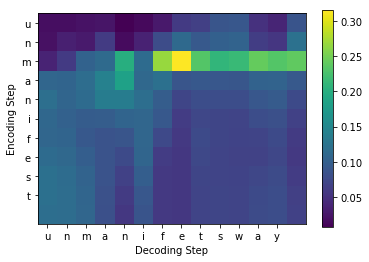

In [155]:
attention_matrix,translated = sess.run([attention_values,pred],feed_dict=fd)
fw_o = np.ndarray((max_out,alphabet_size))
for i in range(max_out):
    fw_o[i]=translated[i*batch_size]
translated_word = unvectorizeWord(fw_o)
input_word = unvectorizeWord(x[0])
plt.imshow(attention_matrix)
plt.colorbar()
plt.xticks(np.arange(len(translated_word)),translated_word)
plt.yticks(np.arange(len(input_word)),input_word)
plt.ylabel('Encoding Step')
plt.xlabel('Decoding Step')

In [147]:
input_word

'~~~~~~pary'

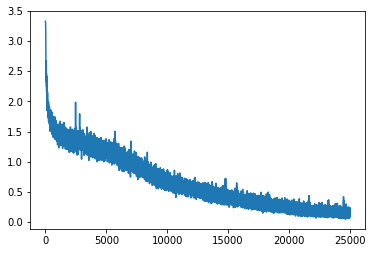

In [156]:
plt.plot(losses)

In [143]:
with g.as_default():
    val_sequence = list()
    for i in range(max_in+1):
        val_sequence.append(tf.placeholder(tf.float32,shape=(1,alphabet_size)))
    logits_val,_ = model(val_sequence,train=False)
    pred_val = tf.nn.softmax(logits_val)

(11,)
(11, 14)


In [157]:
#validation
for s in range(len(uncommon)):
    inputs = vectorizeWord(pad_in(uncommon[s][::-1]))
    
    fd = {}
    for i in range(len(inputs)):
        fd[val_sequence[i]] = np.expand_dims(inputs[i],0)
    
    translated = sess.run([pred_val],feed_dict=fd)[0]
    print 'Input:          ',uncommon[s]
    print 'Output:         ',unvectorizeWord(translated)
    print ' '

Input:           abaya
Output:          ayabaway~~~~~
 
Input:           bardolatry
Output:          aludrilkcray~
 
Input:           blatherski
Output:          issretrallway
 
Input:           couthy
Output:          uochyyay~~~~~
 
Input:           deterge
Output:          egretedway~~~
 
Input:           eyewater
Output:          etaweyeray~~~
 
Input:           saudade
Output:          edadeasway~~~
 
Input:           tokoloshe
Output:          ehsologotway~
 
Input:           wittol
Output:          ottiwlay~~~~~
 
Input:           vomitous
Output:          uotimovsay~~~
 
Input:           waitron
Output:          ortiawnay~~~~
 


# Get Variables

In [32]:
model_params = sess.run([e1_var,e2_var,e3_var,d1_var,d2_var,d3_var,W_softmax,b_softmax])

In [33]:
pickle.dump(model_params,open('params_attention.p','w'))